In [1]:
from utils.config_loader import load_config, assign_config
from processing.climatology import process_climatology
from processing.preprocessing import preprocess_data
from processing.preprocessing_real import preprocess_real_data
from processing.normalize import normalize_data
from model.train import train_model
from model.inference import infer, infer_future
from model.metrics import calculate_rmse
from visualization.plots import plot_heatmaps

config = load_config("./config/params_real.yaml")

### Login to wandb and init experiment

In [2]:
import wandb
import os

os.environ['WANDB_NOTEBOOK_NAME'] = "pipeline.ipynb"
wandb.login()

run = wandb.init(
    project="WindViVit2",
    
    notes="Real data",
    tags=["45 years data", "BERT Base"]
)

wandb_config = wandb.config

assign_config(wandb_config, config)

wandb: Currently logged in as: samuelreyes. Use `wandb login --relogin` to force relogin


### Data preprocessing

In [2]:
process_climatology(config)

In [3]:
preprocess_data(config)

In [4]:
normalize_data(config)

In [2]:
preprocess_real_data(config)

### Training

In [ ]:
train_model(config)

### Evaluate model

In [2]:
results = infer(config)

In [4]:
rmse = calculate_rmse(config, results)
wandb.log({"surface_rmse": rmse["surface_rmse"]})
rmse

array([3.61915669e-01, 3.55904786e-01, 2.60941900e-01, 2.57201225e-01,
       6.21048359e-01, 6.80165420e-01, 1.29410806e-05, 3.14445203e+01,
       4.91023472e-01])

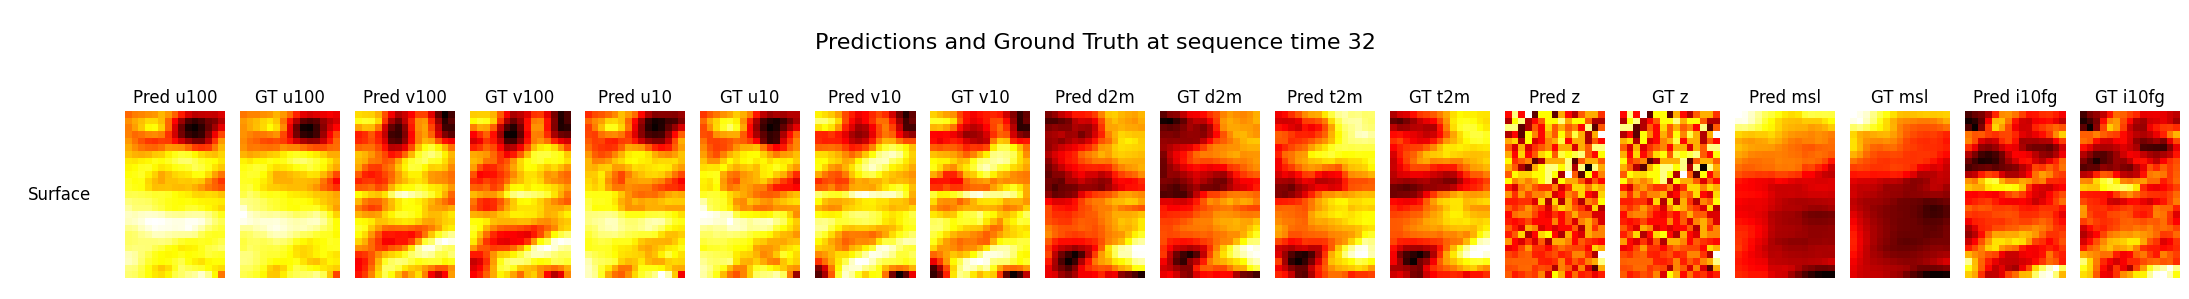

<Figure size 640x480 with 0 Axes>

In [8]:
fig = plot_heatmaps(config, results, 31)
wandb.log({"heatmap": fig})

### Train model with real data

In [ ]:
train_model(config)

In [2]:
results = infer_future(config, 8)

In [19]:
import pickle 


# Ruta del archivo pickle
file_path = '/home/samuelr/projects/WindViViT/project/results_8.pkl'

# Abrir el archivo para lectura en modo binario
with open(file_path, 'rb') as file:
    # Cargar los datos desde el archivo
    results = pickle.load(file)

In [20]:
import numpy as np
import os

years = config['real_data']['years']
image_size = config['model']['image_size_2d']

# Set paths
real_data_path = os.path.join(config['global']['path'], config['global']['real_data_path'])
reanalysis_data_path = os.path.join(config['global']['path'], config['global']['processed_data_path'], 'data.hdf5')
constants_path = os.path.join(config['global']['path'], config['global']['constants_path'])
output_file_path = os.path.join(config['global']['path'], config['global']['processed_data_path'], 'real_data.hdf5')

# Get index of lon and lat for each data point
longitudes = np.load(os.path.join(constants_path, 'longitude.npy'))
latitudes = np.load(os.path.join(constants_path, 'latitude.npy'))

pena_lat = config['real_data']['locations']['pena']['latitude']
pena_lon = config['real_data']['locations']['pena']['longitude']
jara_lat = config['real_data']['locations']['jara']['latitude']
jara_lon = config['real_data']['locations']['jara']['longitude']
minon_lat = config['real_data']['locations']['minon']['latitude']
minon_lon = config['real_data']['locations']['minon']['longitude']

jara_idx = (np.where(latitudes == jara_lat)[0][0], np.where(longitudes == jara_lon)[0][0])
pena_idx = (np.where(latitudes == pena_lat)[0][0], np.where(longitudes == pena_lon)[0][0])
minon_idx = (np.where(latitudes == minon_lat)[0][0], np.where(longitudes == minon_lon)[0][0])

# Get index for wind variables
var_names = ['u100', 'v100', 'u10', 'v10', 'd2m', 't2m', 'z', 'msl', 'i10fg']
u10_idx = var_names.index('u10')
v10_idx = var_names.index('v10')

In [23]:
jara = []
minon = []
pena = []

for i in range(8):
    jara.append([results[i]['prediction'][0,0,jara_idx[0],jara_idx[1],2], results[i]['prediction'][0,0,jara_idx[0],jara_idx[1],3]])
    minon.append([results[i]['prediction'][0,0,minon_idx[0],minon_idx[1],2], results[i]['prediction'][0,0,minon_idx[0],minon_idx[1],3]])
    pena.append([results[i]['prediction'][0,0,pena_idx[0],pena_idx[1],2], results[i]['prediction'][0,0,pena_idx[0],pena_idx[1],3]])


In [24]:
np.set_printoptions(linewidth=300)
results[0]['prediction'][0,0, :, :, 3]

array([[ 5.16191125e-04, -4.41141427e-04, -3.43814492e-04,  4.04633582e-04, -1.53072178e-04,  5.33223152e-04, -2.74197012e-03, -4.39897180e-04,  8.35359097e-05, -2.58214772e-04,  1.58302486e-03, -7.73102045e-04, -2.23308057e-03, -2.33761966e-03, -1.84021890e-03],
       [ 1.47044659e-04,  3.77230346e-04,  2.29507685e-04,  2.46850401e-03,  1.22331083e-04,  5.09008765e-04,  3.74391675e-04, -8.20606947e-05,  2.52524018e-03, -6.57364726e-05, -1.32575631e-04, -3.53969634e-04, -1.31875277e-06, -9.55083251e-01, -1.48409605e-03],
       [ 2.57991254e-04,  3.87236476e-04,  2.85997987e-04,  1.97581947e-04, -1.01678073e-04,  8.56287777e-04,  5.23634255e-04,  4.23334539e-04,  3.66270542e-05, -2.32778490e-04,  5.05462289e-04,  1.13181025e-03,  9.23946500e-04, -8.59886408e-04, -9.80801880e-04],
       [-9.09641385e-05,  2.54139304e-04,  6.38104975e-04,  1.31901242e-02, -3.40864062e-05, -1.01238489e-04,  1.59397721e-04,  4.84697521e-04,  1.23343915e-02, -1.10983849e-04, -1.07865036e-03, -5.06609678e-

In [25]:
minon

[[-0.41958794, -0.95508325],
 [-0.4061162, -0.9478917],
 [-0.3993519, -0.93795645],
 [-0.4079875, -0.9487884],
 [-0.41725674, -0.96673775],
 [-0.4232497, -0.9818294],
 [-0.42765272, -0.9928293],
 [-0.4289074, -0.99723005]]

In [29]:
import h5py

data_path = os.path.join(config['global']['path'], config['global']['processed_data_path'], 'real_data.hdf5')

pena_rea_list = []
jara_rea_list = []
minon_rea_list = []

with h5py.File(data_path, 'r') as file:
    pena_gt = [file['2011']['surface']['data'][31:39,pena_idx[0],pena_idx[1],0], file['2011']['surface']['data'][31:39,pena_idx[0],pena_idx[1],1]]
    jara_gt = [file['2011']['surface']['data'][31:39,jara_idx[0],jara_idx[1],0], file['2011']['surface']['data'][31:39,jara_idx[0],jara_idx[1],1]]
    minon_gt = [file['2011']['surface']['data'][31:39,minon_idx[0],minon_idx[1],0], file['2011']['surface']['data'][31:39,minon_idx[0],minon_idx[1],1]]


In [30]:
import matplotlib.pyplot as plt

def print_results(data, gt):
    # Extrayendo los valores de u y v de cada lista
    u = [item[0] for item in data]
    v = [item[1] for item in data]
    u_gt = gt[0]
    v_gt = gt[1]

    # Creación del plot para u
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(u, label='u Medición')
    plt.plot(u_gt, label='u Ground Truth', linestyle='--')
    plt.title('Comparación de u vs u Ground Truth')
    plt.xlabel('Índice')
    plt.ylabel('Valor de u')
    plt.legend()

    # Creación del plot para v
    plt.subplot(1, 2, 2)
    plt.plot(v, label='v Medición')
    plt.plot(v_gt, label='v Ground Truth', linestyle='--')
    plt.title('Comparación de v vs v Ground Truth')
    plt.xlabel('Índice')
    plt.ylabel('Valor de v')
    plt.legend()

    # Mostrar los gráficos
    plt.tight_layout()
    plt.show()

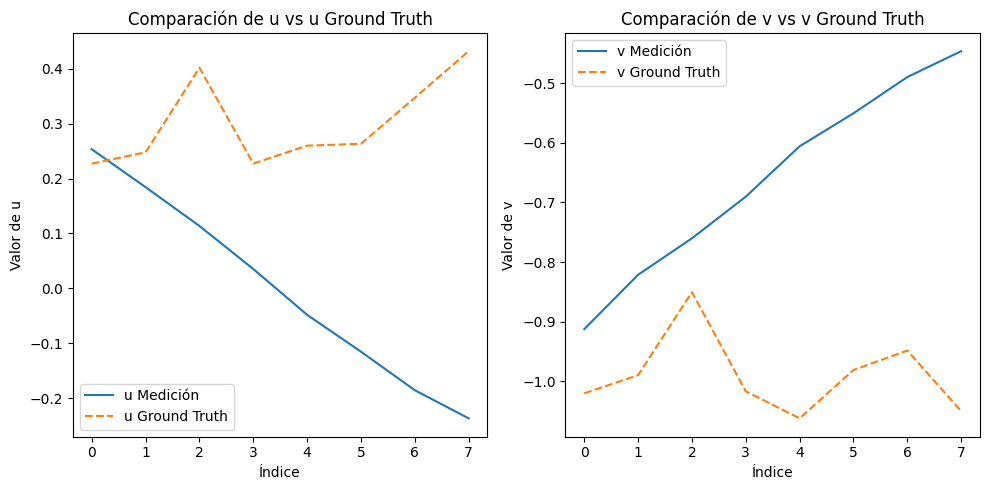

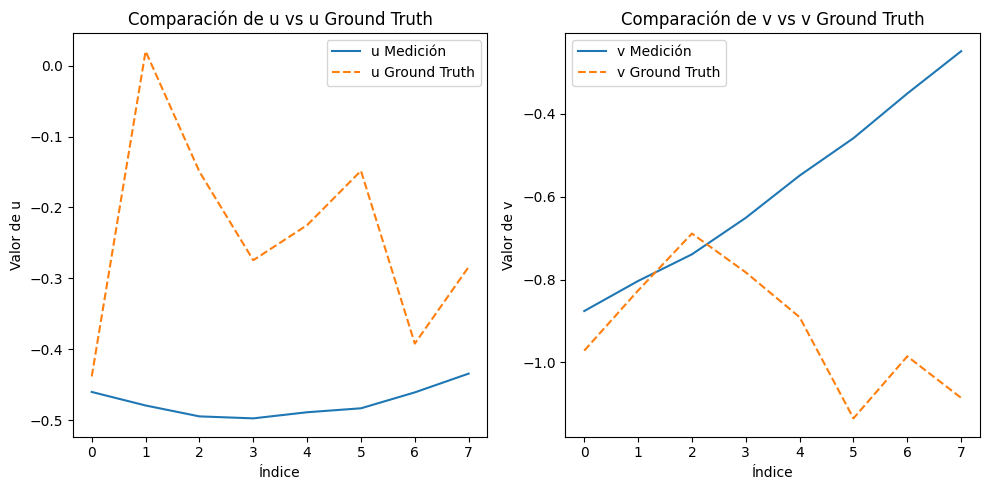

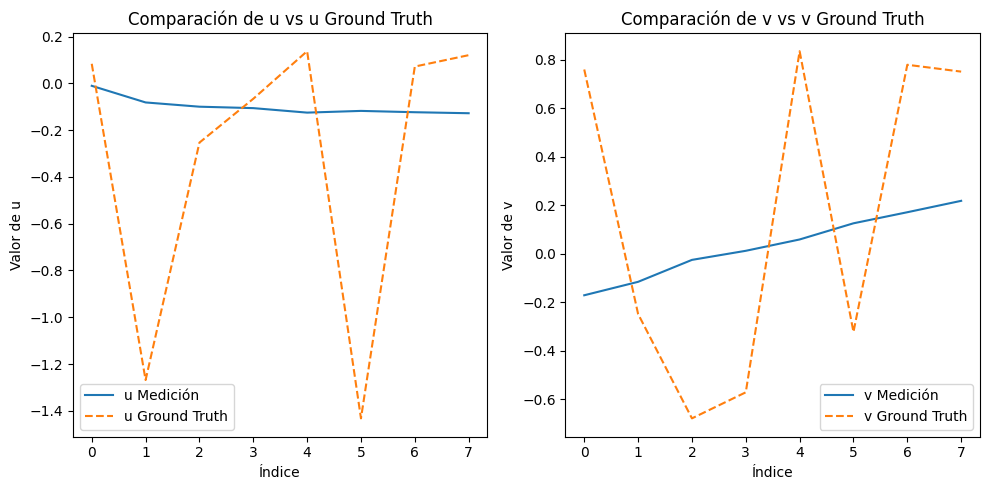

In [73]:
print_results(jara, jara_gt)
print_results(minon, minon_gt)
print_results(pena, pena_gt)

In [17]:
import pickle 

with open('results_8.pkl', 'wb') as archivo:
    pickle.dump(results, archivo)

In [ ]:
run.finish()

In [70]:
import torch
import numpy as np
import os
from torch.utils.data import DataLoader
from model.dataset import HDF5CustomDataset
from model.model_instance import init_model, device

config = load_config("./config/params_real.yaml")

def infer_future(config, future_steps):
    """
    Performs multi-step inference into the future using a pretrained model.

    Parameters:
    - config (dict): Configuration dictionary.
    - future_steps (int): Number of future steps to predict.

    Returns:
    - results (list of dicts): A list of dictionaries containing predictions for each future step.
    """

    # Initialize and load the model
    model = init_model(config)
    model_path = "/home/samuelr/projects/WindViViT/project/checkpoints/model_11_real.pth"
    model.load_state_dict(torch.load(model_path, map_location='cuda'))
    model.eval()

    # Initialize device
    model.to(device)

    data_path = os.path.join(config['global']['path'], config['global']['processed_data_path'], 'real_data.hdf5')


    with h5py.File(data_path, 'r') as file:
    
        input_seq = file['2011']['surface']['data'][0:32,:,:,:]
        input_seq = input_seq[np.newaxis, ...]
        input_seq = torch.from_numpy(input_seq).float()
        input_seq = input_seq.to(device)

    results = []
    with torch.no_grad():

        for step in range(future_steps):
            # Predict the next time step
            print(input_seq[:,:,jara_idx[0],jara_idx[1],1])
            output = model(input_seq)[:,-1:]
            results.append({
                'step': step,
                'prediction': output.cpu().numpy()
            })

            # Update the input sequence with the new prediction
            if step < future_steps - 1:
                new_input = torch.cat((input_seq[:, 1:, :], output), dim=1)
                input_seq = new_input

    return results


In [71]:
resultados = infer_future(config, 8)

tensor([[-0.5593, -0.5861, -0.5554, -0.5017, -0.4669, -0.6009, -0.5374, -0.6104,
         -0.6218, -0.7413, -0.7719, -0.9876, -1.1823, -1.0053, -0.9811, -0.9664,
         -0.8735, -0.8168, -0.6463, -0.6723, -0.8061, -0.8561, -0.8683, -1.1161,
         -0.9415, -0.8006, -0.2170, -0.7096, -0.6917, -0.6199, -0.8081, -1.0204]],
       device='cuda:0')
tensor([[-0.5861, -0.5554, -0.5017, -0.4669, -0.6009, -0.5374, -0.6104, -0.6218,
         -0.7413, -0.7719, -0.9876, -1.1823, -1.0053, -0.9811, -0.9664, -0.8735,
         -0.8168, -0.6463, -0.6723, -0.8061, -0.8561, -0.8683, -1.1161, -0.9415,
         -0.8006, -0.2170, -0.7096, -0.6917, -0.6199, -0.8081, -1.0204, -0.9127]],
       device='cuda:0')
tensor([[-0.5554, -0.5017, -0.4669, -0.6009, -0.5374, -0.6104, -0.6218, -0.7413,
         -0.7719, -0.9876, -1.1823, -1.0053, -0.9811, -0.9664, -0.8735, -0.8168,
         -0.6463, -0.6723, -0.8061, -0.8561, -0.8683, -1.1161, -0.9415, -0.8006,
         -0.2170, -0.7096, -0.6917, -0.6199, -0.8081, -1.

In [72]:
jara = []
minon = []
pena = []

for i in range(8):
    jara.append([resultados[i]['prediction'][0,0,jara_idx[0],jara_idx[1],0], resultados[i]['prediction'][0,0,jara_idx[0],jara_idx[1],1]])
    minon.append([resultados[i]['prediction'][0,0,minon_idx[0],minon_idx[1],0], resultados[i]['prediction'][0,0,minon_idx[0],minon_idx[1],1]])
    pena.append([resultados[i]['prediction'][0,0,pena_idx[0],pena_idx[1],0], resultados[i]['prediction'][0,0,pena_idx[0],pena_idx[1],1]])